In [1]:
import pandas as pd
import numpy as np
pd.__version__

/data/fantasy_football/virtualenvs/daily-fantasy/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/fantasy_football/virtualenvs/daily-fantasy/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


'0.23.4'

In [2]:
df = pd.read_csv("./data/updated_table.csv")

In [4]:
# Drop na to not mess with the training
clean_df = df.dropna()
clean_df.shape

(9984, 19)

### Split data for training and testing

In [5]:
train = clean_df[clean_df.apply(lambda x: x['Year'] == 2015, axis=1)]
test = clean_df[clean_df.apply(lambda x: x['Year'] == 2016, axis=1)]
cv = clean_df[clean_df.apply(lambda x: x['Year'] == 2017, axis=1)]

## Implement the model

In [6]:
import theano
import pymc3 as pm
theano.__version__

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\ProgramData\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv im

'1.0.2'

In [7]:
train.head()

,Player,pos_id,Team,Opponent,Pts,Week,Year,Position_QB,Position_RB,Position_TE,Position_WR,opp_team,team,player_id,5_game_avg,is_home,diff_from_avg,week_year,rank
8000,Julio Jones,WR,ATL,PHI,35.0,1,2015,0,0,0,1,19,14,314,29.0,0,6.0,1_2015,0.0
8001,Tom Brady,QB,NE,PIT,35.0,1,2015,1,0,0,0,10,3,8,24.6,0,10.4,1_2015,0.0
8003,DeAndre Hopkins,WR,HOU,KC,32.0,1,2015,0,0,0,1,12,2,481,24.6,0,7.4,1_2015,0.0
8004,Rob Gronkowski,TE,NE,PIT,32.0,1,2015,0,0,1,0,10,3,167,20.6,0,11.4,1_2015,1.0
8005,Carson Palmer,QB,ARI,NO,31.0,1,2015,1,0,0,0,23,15,17,24.6,0,6.4,1_2015,0.0


In [10]:
ids = np.array([k for k in df['Opponent'].unique()])
team_names = ids.copy()

In [11]:
num_positions=4
ranks=5
team_number = len(team_names)
np.random.seed(42)

with pm.Model() as model:
    nu = pm.Exponential('nu minus one', 1/29.,shape=2) + 1 # from https://pymc-devs.github.io/pymc3/notebooks/BEST.html
    err = pm.Uniform('std dev based on rank', 0, 100, shape=ranks)
    err_b = pm.Uniform('std dev based on rank b', 0, 100, shape=ranks)

    # Theano shared variables to change at test time
    player_home = theano.shared(np.asarray(train['is_home'].values, dtype = int))
    player_avg = theano.shared(np.asarray((train['5_game_avg']).values, dtype = float))
    player_opp = theano.shared(np.asarray((train['opp_team']).values, dtype = int))
    player_team = theano.shared(np.asarray((train['team']).values, dtype = int))
    player_rank = theano.shared(np.asarray((train['rank']).values, dtype = int))
    qb = theano.shared(np.asarray((train['Position_QB']).values.astype(int), dtype = int))
    wr = theano.shared(np.asarray((train['Position_WR']).values.astype(int), dtype = int))
    rb = theano.shared(np.asarray((train['Position_RB']).values.astype(int), dtype = int))
    te = theano.shared(np.asarray((train['Position_TE']).values.astype(int), dtype = int))
    pos_id = theano.shared(np.asarray((train['pos_id']).values, dtype = str))


In [12]:
with model:
    # Defensive ability of the opposing team vs. each position, partially pooled
    opp_def = pm.Normal('opp team prior',0, sd=100**2, shape=num_positions)
    opp_qb = pm.Normal('defensive differential qb', opp_def[0], sd=100**2, shape=team_number)
    opp_wr = pm.Normal('defensive differential wr', opp_def[1], sd=100**2, shape=team_number)
    opp_rb = pm.Normal('defensive differential rb', opp_def[2], sd=100**2, shape=team_number)
    opp_te = pm.Normal('defensive differential te', opp_def[3], sd=100**2, shape=team_number)
    
    # Partially pooled ability of the player's rank partially pooled based on position
    home_adv = pm.Normal('home additivie prior', 0, 100**2,shape = num_positions)     
    away_adv = pm.Normal('away additivie prior', 0, 100**2,shape = num_positions)     
    pos_home_qb = pm.Normal('home differential qb',home_adv[0],10**2, shape = ranks)
    pos_home_rb = pm.Normal('home differential rb',home_adv[1],10**2, shape = ranks)
    pos_home_te = pm.Normal('home differential te',home_adv[2],10**2, shape = ranks)
    pos_home_wr = pm.Normal('home differential wr',home_adv[3],10**2, shape = ranks)
    pos_away_qb = pm.Normal('away differential qb',away_adv[0],10**2, shape = ranks)
    pos_away_rb = pm.Normal('away differential rb',away_adv[1],10**2, shape = ranks)
    pos_away_wr = pm.Normal('away differential wr',away_adv[2],10**2, shape = ranks)
    pos_away_te = pm.Normal('away differential te',away_adv[3],10**2, shape = ranks)

In [13]:
with model:
    # First likelihood where the player's difference from average is explained by defensive abililty
    def_effect = qb*opp_qb[player_opp]+ wr*opp_wr[player_opp]+ rb*opp_rb[player_opp]+ te*opp_te[player_opp]
    like1 = pm.StudentT('Diff From Avg', mu=def_effect, sd=err_b[player_rank],nu=nu[1], observed = train['diff_from_avg'])
    
    # Second likelihood where the score is predicted by defensive power plus other smaller factors
    mu = player_avg + def_effect
    mu += rb*pos_home_rb[player_rank]*(player_home) + wr*pos_home_wr[player_rank]*(player_home) 
    mu += qb*pos_home_qb[player_rank]*(player_home) + te*pos_home_te[player_rank]*(player_home) 
    mu += rb*pos_away_rb[player_rank]*(1-player_home) + wr*pos_away_wr[player_rank]*(1-player_home) 
    mu += qb*pos_away_qb[player_rank]*(1-player_home) + te*pos_away_te[player_rank]*(1-player_home) 
    like2 = pm.StudentT('Score', mu=mu, sd=err[player_rank], nu=nu[0], observed=train['Pts'])



In [17]:
with model:
    # Training!
    trace=pm.sample(10000, pm.Metropolis())

Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [away differential te]
>Metropolis: [away differential wr]
>Metropolis: [away differential rb]
>Metropolis: [away differential qb]
>Metropolis: [home differential wr]
>Metropolis: [home differential te]
>Metropolis: [home differential rb]
>Metropolis: [home differential qb]
>Metropolis: [away additivie prior]
>Metropolis: [home additivie prior]
>Metropolis: [defensive differential te]
>Metropolis: [defensive differential rb]
>Metropolis: [defensive differential wr]
>Metropolis: [defensive differential qb]
>Metropolis: [opp team prior]
>Metropolis: [std dev based on rank b]
>Metropolis: [std dev based on rank]
>Metropolis: [nu minus one]

Sampling 4 chains:   0%|▌                                                                                                                                                                             | 8/2400 [01:29<7:38:23, 11.50s/draws]

ValueError: Not enough samples to build a trace.

In [3]:
import pickle

In [4]:
with open('/data/fantasy_football/model.pkl', 'rb') as r:
    data = pickle.load(r)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
import matplotlib

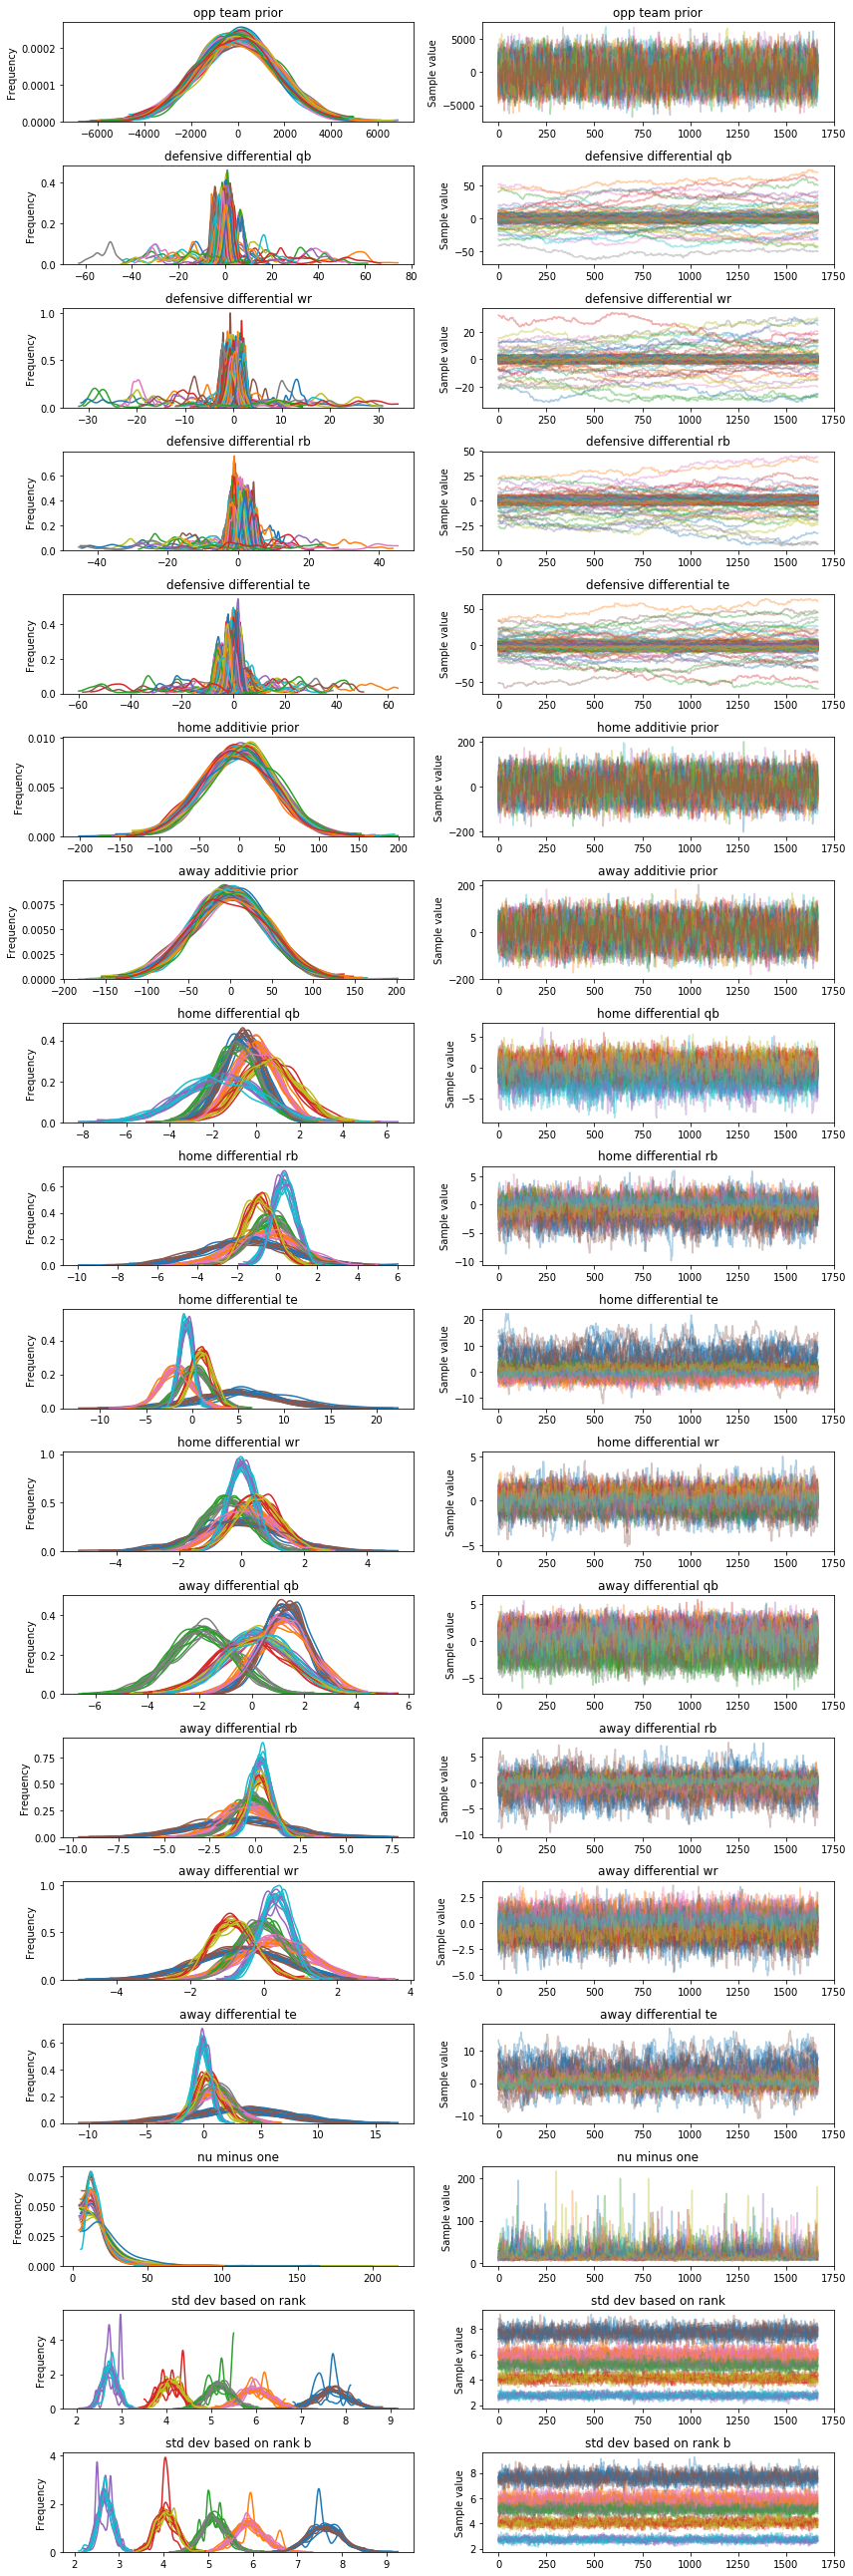

In [9]:
import pymc3 as pm
trace = data['trace']
tr=trace[-5000::3]
%matplotlib inline
_=pm.traceplot(tr)

In [35]:
model = data['model']
a = model['defensive differential te']
x = pm.summary(trace)#.index.map(lambda x: x.startswith('defensive differential').sum())

In [46]:
x[x.index.map(lambda x: x.startswith('defensive differential qb'))]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
defensive differential qb__0,0.116957,1.286809,0.032659,-2.425074,2.702789,1638.711837,1.005176
defensive differential qb__1,2.056601,1.269806,0.030825,-0.474352,4.528160,1489.144260,1.005258
defensive differential qb__2,1.455340,1.474329,0.045704,-1.447898,4.328813,1088.265003,1.009002
defensive differential qb__3,-0.173668,1.417271,0.038127,-3.043713,2.571151,1384.135659,1.003653
defensive differential qb__4,0.676463,1.024944,0.018795,-1.328024,2.630901,2224.448715,1.002258
defensive differential qb__5,0.618764,1.395123,0.043578,-2.258194,3.300307,1151.231790,1.006601
defensive differential qb__6,-0.045721,1.727424,0.051492,-3.458461,3.242245,942.354321,1.010109
defensive differential qb__7,-1.444480,1.329534,0.032398,-4.055990,1.164263,1467.918737,1.004686
defensive differential qb__8,0.336030,1.487722,0.042615,-2.585186,3.310309,1180.992573,1.004679
defensive differential qb__9,-3.995902,1.605247,0.048895,-7.103504,-0.801328,1050.430714,1.003446
